# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Model Selection

In this jupyter notebook, we will try multiple models for prediction and choose the best fitting one.

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from src.preprocessing.helpers import describe_dataset
from src.evaluation import compare_models, evaluate_model, roc_auc

### Load train and test data

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv', header=None, names=['label'])
y_test = pd.read_csv('../data/y_test.csv', header=None, names=['label'])

In [5]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data:  81409
Number of test data:   20353
With  58  features.
In  2  classes:
               0 :  72315  samples,  0.89%
               1 :  9094  samples,  0.11%


### Models training and evaluation

We will evaluate three models:
* Random forest
* Naive Bayes
* SVM

To final evaluation will be choosen a model with highest accuracy.

#### Random Forest

              precision    recall  f1-score   support

           0       0.92      0.68      0.78     18090
           1       0.17      0.52      0.26      2263

    accuracy                           0.67     20353
   macro avg       0.54      0.60      0.52     20353
weighted avg       0.84      0.67      0.73     20353

ROC AUC score: 0.60


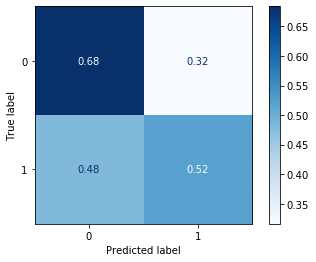

In [14]:
clf = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=100, max_features=58, 
                             class_weight={0:1, 1:8})
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)

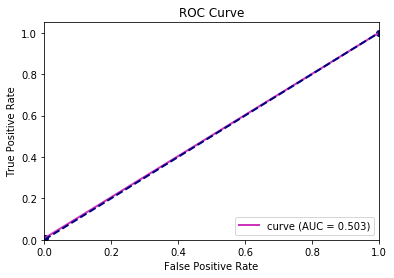

In [7]:
roc_auc(clf.predict(X_test), y_test);

#### Naive Bayes

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     18090
           1       0.23      0.16      0.19      2263

    accuracy                           0.85     20353
   macro avg       0.57      0.55      0.55     20353
weighted avg       0.82      0.85      0.83     20353

ROC AUC score: 0.55


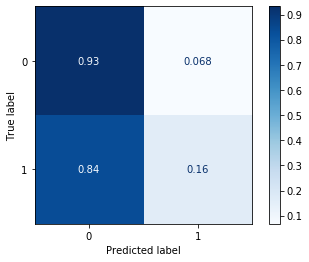

In [8]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
evaluate_model(gnb, X_test, y_test)

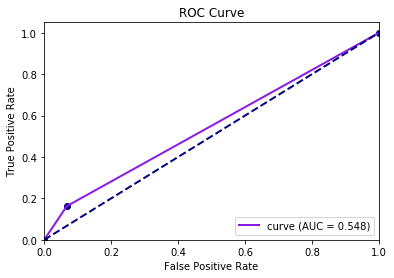

In [9]:
roc_auc(gnb.predict(X_test), y_test);

#### SVM

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     18090
           1       0.07      0.01      0.02      2263

    accuracy                           0.87     20353
   macro avg       0.48      0.50      0.48     20353
weighted avg       0.80      0.87      0.83     20353

ROC AUC score: 0.50


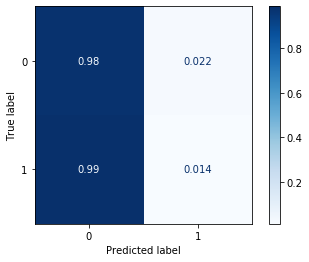

In [10]:
svc = svm.SVC(gamma='auto', max_iter=100)
svc.fit(X_train, y_train)
evaluate_model(svc, X_test, y_test)

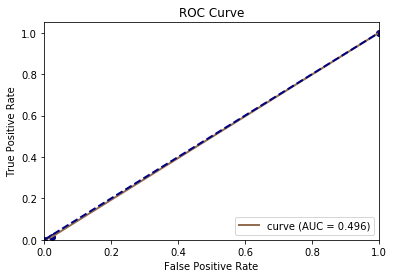

In [11]:
roc_auc(svc.predict(X_test), y_test);

### Finall comparision of models

In [15]:
compare_models([clf, gnb, svc], ['Random forest', 'Naive bayes', 'SVM'], X_test, y_test)

                  Accuracy   F1 (micro)   F1 (macro)   Precission    Recall    AUC ROC
Random forest: |   0.67   |    0.67    |    0.52    |    0.17    |   0.52   |   0.60   |
Naive bayes  : |   0.85   |    0.85    |    0.55    |    0.23    |   0.16   |   0.55   |
SVM          : |   0.87   |    0.87    |    0.48    |    0.07    |   0.01   |   0.50   |
